In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = "MNIST"
model_name = "flow_vcr_mse"
ood = "0"

In [3]:
# Parameters
ood = 1


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

  0%|                                                                             | 0/60000 [00:00<?, ?it/s]

 11%|██████▋                                                        | 6403/60000 [00:00<00:00, 64018.46it/s]

 22%|█████████████▌                                                | 13096/60000 [00:00<00:00, 65725.97it/s]

 33%|████████████████████▍                                         | 19772/60000 [00:00<00:00, 66197.40it/s]

 44%|███████████████████████████▍                                  | 26510/60000 [00:00<00:00, 66660.07it/s]

 55%|██████████████████████████████████▎                           | 33177/60000 [00:00<00:00, 66373.12it/s]

 66%|█████████████████████████████████████████▏                    | 39815/60000 [00:00<00:00, 66177.46it/s]

 78%|████████████████████████████████████████████████▏             | 46630/60000 [00:00<00:00, 66819.16it/s]

 89%|███████████████████████████████████████████████████████▏      | 53413/60000 [00:00<00:00, 67139.19it/s]

100%|██████████████████████████████████████████████████████████████| 60000/60000 [00:00<00:00, 66525.43it/s]

  0%|                                                                             | 0/10000 [00:00<?, ?it/s]

 67%|██████████████████████████████████████████                     | 6684/10000 [00:00<00:00, 66830.82it/s]

100%|██████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 65847.64it/s]

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
model_ids = {
    "0:1:2:3:4": '59ftut3f',
    "5:6:7:8:9": "lz2g3fq1",
    "0": "cpnxtpv2",
    "1": "c6sohudf",
    "2": "5qeniujh",
    "3": "cto6ipr0",
}
ood_str = ":".join(map(str, config.ood))
model_id = model_ids[ood_str]
print(ood_str, model_id)

1 c6sohudf


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robust_ml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from models.common import edl_probs
from tqdm import tqdm

trn_targets = []
val_targets = []
ind_targets = []
if ood_str:
    ood_targets = []

trn_u_norms = []
val_u_norms = []
ind_u_norms = []
if ood_str:
    ood_u_norms = []
rnd_u_norms = []

trn_v_norms = []
val_v_norms = []
ind_v_norms = []
if ood_str:
    ood_v_norms = []
rnd_v_norms = []

# train set (ind)
for batch_idx, batch in enumerate(tqdm(train_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    trn_u_norms.extend(u_norm.detach().cpu().numpy())
    trn_v_norms.extend(v_norm.detach().cpu().numpy())
    trn_targets.extend(y.detach().cpu().numpy())
print("train - OK")

# val set (ind)
for batch_idx, batch in enumerate(tqdm(val_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    val_u_norms.extend(u_norm.detach().cpu().numpy())
    val_v_norms.extend(v_norm.detach().cpu().numpy())
    val_targets.extend(y.detach().cpu().numpy())
print("val - OK")

# test set (ind)
for batch_idx, batch in enumerate(tqdm(test_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    ind_u_norms.extend(u_norm.detach().cpu().numpy())
    ind_v_norms.extend(v_norm.detach().cpu().numpy())
    ind_targets.extend(y.detach().cpu().numpy())
print("test InD - OK")

# predict set (ood)
if ood_str:
    for batch_idx, batch in enumerate(tqdm(predict_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        v, z, x_m, u_norm, v_norm, logits = model(x)
        ood_u_norms.extend(u_norm.detach().cpu().numpy())
        ood_v_norms.extend(v_norm.detach().cpu().numpy())
        ood_targets.extend(y.detach().cpu().numpy())
    print("test OoD - OK")

# random set
rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
for batch_idx, batch in enumerate(tqdm(rnd_set)):
    x = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    rnd_u_norms.extend(u_norm.detach().cpu().numpy())
    rnd_v_norms.extend(v_norm.detach().cpu().numpy())
print("test RnD - OK")

trn_targets = np.array(trn_targets).squeeze()
val_targets = np.array(val_targets).squeeze()
ind_targets = np.array(ind_targets).squeeze()
if ood_str:
    ood_targets = np.array(ood_targets).squeeze()

trn_u_norms = np.array(trn_u_norms).squeeze()
val_u_norms = np.array(val_u_norms).squeeze()
ind_u_norms = np.array(ind_u_norms).squeeze()
if ood_str:
    ood_u_norms = np.array(ood_u_norms).squeeze()
rnd_u_norms = np.array(rnd_u_norms).squeeze()

trn_v_norms = np.array(trn_v_norms).squeeze()
val_v_norms = np.array(val_v_norms).squeeze()
ind_v_norms = np.array(ind_v_norms).squeeze()
if ood_str:
    ood_v_norms = np.array(ood_v_norms).squeeze()
rnd_v_norms = np.array(rnd_v_norms).squeeze()

print(trn_u_norms.shape, trn_v_norms.shape)
print(val_u_norms.shape, val_v_norms.shape)
print(ind_u_norms.shape, ind_v_norms.shape)
if ood_str:
    print(ood_u_norms.shape, ood_v_norms.shape)
print(rnd_u_norms.shape, rnd_v_norms.shape)

  0%|                                                                               | 0/666 [00:00<?, ?it/s]

  0%|                                                                       | 1/666 [00:00<09:17,  1.19it/s]

  1%|▍                                                                      | 4/666 [00:00<02:03,  5.37it/s]

  1%|▊                                                                      | 8/666 [00:01<01:00, 10.85it/s]

  2%|█▏                                                                    | 11/666 [00:01<00:45, 14.46it/s]

  2%|█▌                                                                    | 15/666 [00:01<00:34, 18.95it/s]

  3%|█▉                                                                    | 19/666 [00:01<00:28, 22.49it/s]

  3%|██▍                                                                   | 23/666 [00:01<00:25, 25.09it/s]

  4%|██▊                                                                   | 27/666 [00:01<00:24, 26.61it/s]

  5%|███▎                                                                  | 31/666 [00:01<00:22, 28.28it/s]

  5%|███▋                                                                  | 35/666 [00:01<00:21, 29.47it/s]

  6%|████                                                                  | 39/666 [00:02<00:20, 30.34it/s]

  6%|████▌                                                                 | 43/666 [00:02<00:20, 30.92it/s]

  7%|████▉                                                                 | 47/666 [00:02<00:19, 31.25it/s]

  8%|█████▎                                                                | 51/666 [00:02<00:19, 31.59it/s]

  8%|█████▊                                                                | 55/666 [00:02<00:19, 31.81it/s]

  9%|██████▏                                                               | 59/666 [00:02<00:18, 31.95it/s]

  9%|██████▌                                                               | 63/666 [00:02<00:18, 32.11it/s]

 10%|███████                                                               | 67/666 [00:02<00:18, 32.21it/s]

 11%|███████▍                                                              | 71/666 [00:03<00:18, 32.21it/s]

 11%|███████▉                                                              | 75/666 [00:03<00:18, 31.49it/s]

 12%|████████▎                                                             | 79/666 [00:03<00:18, 31.70it/s]

 12%|████████▋                                                             | 83/666 [00:03<00:18, 31.84it/s]

 13%|█████████▏                                                            | 87/666 [00:03<00:18, 31.95it/s]

 14%|█████████▌                                                            | 91/666 [00:03<00:17, 32.03it/s]

 14%|█████████▉                                                            | 95/666 [00:03<00:17, 32.05it/s]

 15%|██████████▍                                                           | 99/666 [00:03<00:17, 32.12it/s]

 15%|██████████▋                                                          | 103/666 [00:04<00:17, 32.04it/s]

 16%|███████████                                                          | 107/666 [00:04<00:17, 32.08it/s]

 17%|███████████▌                                                         | 111/666 [00:04<00:17, 32.14it/s]

 17%|███████████▉                                                         | 115/666 [00:04<00:17, 32.18it/s]

 18%|████████████▎                                                        | 119/666 [00:04<00:16, 32.20it/s]

 18%|████████████▋                                                        | 123/666 [00:04<00:16, 32.13it/s]

 19%|█████████████▏                                                       | 127/666 [00:04<00:16, 32.16it/s]

 20%|█████████████▌                                                       | 131/666 [00:04<00:16, 32.21it/s]

 20%|█████████████▉                                                       | 135/666 [00:05<00:16, 32.21it/s]

 21%|██████████████▍                                                      | 139/666 [00:05<00:16, 32.20it/s]

 21%|██████████████▊                                                      | 143/666 [00:05<00:16, 32.19it/s]

 22%|███████████████▏                                                     | 147/666 [00:05<00:16, 32.20it/s]

 23%|███████████████▋                                                     | 151/666 [00:05<00:16, 32.12it/s]

 23%|████████████████                                                     | 155/666 [00:05<00:15, 32.05it/s]

 24%|████████████████▍                                                    | 159/666 [00:05<00:15, 32.16it/s]

 24%|████████████████▉                                                    | 163/666 [00:05<00:15, 32.59it/s]

 25%|█████████████████▎                                                   | 167/666 [00:06<00:15, 32.96it/s]

 26%|█████████████████▋                                                   | 171/666 [00:06<00:14, 33.27it/s]

 26%|██████████████████▏                                                  | 175/666 [00:06<00:14, 33.38it/s]

 27%|██████████████████▌                                                  | 179/666 [00:06<00:14, 33.45it/s]

 27%|██████████████████▉                                                  | 183/666 [00:06<00:14, 33.45it/s]

 28%|███████████████████▎                                                 | 187/666 [00:06<00:14, 33.26it/s]

 29%|███████████████████▊                                                 | 191/666 [00:06<00:14, 33.18it/s]

 29%|████████████████████▏                                                | 195/666 [00:06<00:14, 33.23it/s]

 30%|████████████████████▌                                                | 199/666 [00:06<00:14, 32.54it/s]

 30%|█████████████████████                                                | 203/666 [00:07<00:14, 32.69it/s]

 31%|█████████████████████▍                                               | 207/666 [00:07<00:13, 33.08it/s]

 32%|█████████████████████▊                                               | 211/666 [00:07<00:13, 33.33it/s]

 32%|██████████████████████▎                                              | 215/666 [00:07<00:13, 33.33it/s]

 33%|██████████████████████▋                                              | 219/666 [00:07<00:13, 33.51it/s]

 33%|███████████████████████                                              | 223/666 [00:07<00:13, 33.62it/s]

 34%|███████████████████████▌                                             | 227/666 [00:07<00:13, 33.75it/s]

 35%|███████████████████████▉                                             | 231/666 [00:07<00:12, 33.79it/s]

 35%|████████████████████████▎                                            | 235/666 [00:08<00:12, 33.86it/s]

 36%|████████████████████████▊                                            | 239/666 [00:08<00:12, 33.93it/s]

 36%|█████████████████████████▏                                           | 243/666 [00:08<00:12, 33.94it/s]

 37%|█████████████████████████▌                                           | 247/666 [00:08<00:12, 33.99it/s]

 38%|██████████████████████████                                           | 251/666 [00:08<00:12, 33.97it/s]

 38%|██████████████████████████▍                                          | 255/666 [00:08<00:12, 33.96it/s]

 39%|██████████████████████████▊                                          | 259/666 [00:08<00:11, 33.98it/s]

 39%|███████████████████████████▏                                         | 263/666 [00:08<00:11, 33.94it/s]

 40%|███████████████████████████▋                                         | 267/666 [00:08<00:11, 33.95it/s]

 41%|████████████████████████████                                         | 271/666 [00:09<00:11, 33.96it/s]

 41%|████████████████████████████▍                                        | 275/666 [00:09<00:11, 34.01it/s]

 42%|████████████████████████████▉                                        | 279/666 [00:09<00:11, 33.99it/s]

 42%|█████████████████████████████▎                                       | 283/666 [00:09<00:11, 34.01it/s]

 43%|█████████████████████████████▋                                       | 287/666 [00:09<00:11, 34.05it/s]

 44%|██████████████████████████████▏                                      | 291/666 [00:09<00:11, 33.98it/s]

 44%|██████████████████████████████▌                                      | 295/666 [00:09<00:10, 33.93it/s]

 45%|██████████████████████████████▉                                      | 299/666 [00:09<00:10, 33.92it/s]

 45%|███████████████████████████████▍                                     | 303/666 [00:10<00:10, 33.69it/s]

 46%|███████████████████████████████▊                                     | 307/666 [00:10<00:10, 32.93it/s]

 47%|████████████████████████████████▏                                    | 311/666 [00:10<00:10, 32.65it/s]

 47%|████████████████████████████████▋                                    | 315/666 [00:10<00:10, 32.38it/s]

 48%|█████████████████████████████████                                    | 319/666 [00:10<00:10, 32.27it/s]

 48%|█████████████████████████████████▍                                   | 323/666 [00:10<00:10, 32.26it/s]

 49%|█████████████████████████████████▉                                   | 327/666 [00:10<00:10, 32.17it/s]

 50%|██████████████████████████████████▎                                  | 331/666 [00:10<00:10, 32.09it/s]

 50%|██████████████████████████████████▋                                  | 335/666 [00:11<00:10, 32.15it/s]

 51%|███████████████████████████████████                                  | 339/666 [00:11<00:10, 32.24it/s]

 52%|███████████████████████████████████▌                                 | 343/666 [00:11<00:09, 32.59it/s]

 52%|███████████████████████████████████▉                                 | 347/666 [00:11<00:09, 32.72it/s]

 53%|████████████████████████████████████▎                                | 351/666 [00:11<00:09, 32.63it/s]

 53%|████████████████████████████████████▊                                | 355/666 [00:11<00:09, 32.40it/s]

 54%|█████████████████████████████████████▏                               | 359/666 [00:11<00:09, 32.21it/s]

 55%|█████████████████████████████████████▌                               | 363/666 [00:11<00:09, 32.13it/s]

 55%|██████████████████████████████████████                               | 367/666 [00:12<00:09, 32.03it/s]

 56%|██████████████████████████████████████▍                              | 371/666 [00:12<00:09, 32.06it/s]

 56%|██████████████████████████████████████▊                              | 375/666 [00:12<00:09, 32.05it/s]

 57%|███████████████████████████████████████▎                             | 379/666 [00:12<00:08, 32.05it/s]

 58%|███████████████████████████████████████▋                             | 383/666 [00:12<00:08, 32.02it/s]

 58%|████████████████████████████████████████                             | 387/666 [00:12<00:08, 31.96it/s]

 59%|████████████████████████████████████████▌                            | 391/666 [00:12<00:08, 32.11it/s]

 59%|████████████████████████████████████████▉                            | 395/666 [00:12<00:08, 32.24it/s]

 60%|█████████████████████████████████████████▎                           | 399/666 [00:13<00:08, 32.25it/s]

 61%|█████████████████████████████████████████▊                           | 403/666 [00:13<00:08, 32.05it/s]

 61%|██████████████████████████████████████████▏                          | 407/666 [00:13<00:08, 31.86it/s]

 62%|██████████████████████████████████████████▌                          | 411/666 [00:13<00:07, 31.95it/s]

 62%|██████████████████████████████████████████▉                          | 415/666 [00:13<00:07, 32.00it/s]

 63%|███████████████████████████████████████████▍                         | 419/666 [00:13<00:07, 32.14it/s]

 64%|███████████████████████████████████████████▊                         | 423/666 [00:13<00:07, 32.22it/s]

 64%|████████████████████████████████████████████▏                        | 427/666 [00:13<00:07, 32.27it/s]

 65%|████████████████████████████████████████████▋                        | 431/666 [00:14<00:07, 32.51it/s]

 65%|█████████████████████████████████████████████                        | 435/666 [00:14<00:07, 32.57it/s]

 66%|█████████████████████████████████████████████▍                       | 439/666 [00:14<00:06, 32.56it/s]

 67%|█████████████████████████████████████████████▉                       | 443/666 [00:14<00:06, 32.47it/s]

 67%|██████████████████████████████████████████████▎                      | 447/666 [00:14<00:06, 32.45it/s]

 68%|██████████████████████████████████████████████▋                      | 451/666 [00:14<00:06, 32.65it/s]

 68%|███████████████████████████████████████████████▏                     | 455/666 [00:14<00:06, 32.90it/s]

 69%|███████████████████████████████████████████████▌                     | 459/666 [00:14<00:06, 31.95it/s]

 70%|███████████████████████████████████████████████▉                     | 463/666 [00:15<00:06, 32.01it/s]

 70%|████████████████████████████████████████████████▍                    | 467/666 [00:15<00:06, 32.13it/s]

 71%|████████████████████████████████████████████████▊                    | 471/666 [00:15<00:05, 32.52it/s]

 71%|█████████████████████████████████████████████████▏                   | 475/666 [00:15<00:05, 32.48it/s]

 72%|█████████████████████████████████████████████████▋                   | 479/666 [00:15<00:05, 32.55it/s]

 73%|██████████████████████████████████████████████████                   | 483/666 [00:15<00:05, 32.56it/s]

 73%|██████████████████████████████████████████████████▍                  | 487/666 [00:15<00:05, 32.54it/s]

 74%|██████████████████████████████████████████████████▊                  | 491/666 [00:15<00:05, 32.49it/s]

 74%|███████████████████████████████████████████████████▎                 | 495/666 [00:16<00:05, 32.47it/s]

 75%|███████████████████████████████████████████████████▋                 | 499/666 [00:16<00:05, 32.56it/s]

 76%|████████████████████████████████████████████████████                 | 503/666 [00:16<00:05, 32.37it/s]

 76%|████████████████████████████████████████████████████▌                | 507/666 [00:16<00:04, 32.29it/s]

 77%|████████████████████████████████████████████████████▉                | 511/666 [00:16<00:04, 32.35it/s]

 77%|█████████████████████████████████████████████████████▎               | 515/666 [00:16<00:04, 32.43it/s]

 78%|█████████████████████████████████████████████████████▊               | 519/666 [00:16<00:04, 32.50it/s]

 79%|██████████████████████████████████████████████████████▏              | 523/666 [00:16<00:04, 32.44it/s]

 79%|██████████████████████████████████████████████████████▌              | 527/666 [00:16<00:04, 32.50it/s]

 80%|███████████████████████████████████████████████████████              | 531/666 [00:17<00:04, 32.43it/s]

 80%|███████████████████████████████████████████████████████▍             | 535/666 [00:17<00:04, 32.43it/s]

 81%|███████████████████████████████████████████████████████▊             | 539/666 [00:17<00:03, 32.95it/s]

 82%|████████████████████████████████████████████████████████▎            | 543/666 [00:17<00:03, 33.26it/s]

 82%|████████████████████████████████████████████████████████▋            | 547/666 [00:17<00:03, 33.60it/s]

 83%|█████████████████████████████████████████████████████████            | 551/666 [00:17<00:03, 33.38it/s]

 83%|█████████████████████████████████████████████████████████▌           | 555/666 [00:17<00:03, 32.99it/s]

 84%|█████████████████████████████████████████████████████████▉           | 559/666 [00:17<00:03, 33.25it/s]

 85%|██████████████████████████████████████████████████████████▎          | 563/666 [00:18<00:03, 33.58it/s]

 85%|██████████████████████████████████████████████████████████▋          | 567/666 [00:18<00:02, 33.77it/s]

 86%|███████████████████████████████████████████████████████████▏         | 571/666 [00:18<00:02, 33.89it/s]

 86%|███████████████████████████████████████████████████████████▌         | 575/666 [00:18<00:02, 33.99it/s]

 87%|███████████████████████████████████████████████████████████▉         | 579/666 [00:18<00:02, 34.05it/s]

 88%|████████████████████████████████████████████████████████████▍        | 583/666 [00:18<00:02, 34.09it/s]

 88%|████████████████████████████████████████████████████████████▊        | 587/666 [00:18<00:02, 34.13it/s]

 89%|█████████████████████████████████████████████████████████████▏       | 591/666 [00:18<00:02, 34.17it/s]

 89%|█████████████████████████████████████████████████████████████▋       | 595/666 [00:19<00:02, 34.22it/s]

 90%|██████████████████████████████████████████████████████████████       | 599/666 [00:19<00:01, 33.63it/s]

 91%|██████████████████████████████████████████████████████████████▍      | 603/666 [00:19<00:01, 33.64it/s]

 91%|██████████████████████████████████████████████████████████████▉      | 607/666 [00:19<00:01, 33.83it/s]

 92%|███████████████████████████████████████████████████████████████▎     | 611/666 [00:19<00:01, 33.98it/s]

 92%|███████████████████████████████████████████████████████████████▋     | 615/666 [00:19<00:01, 33.85it/s]

 93%|████████████████████████████████████████████████████████████████▏    | 619/666 [00:19<00:01, 33.91it/s]

 94%|████████████████████████████████████████████████████████████████▌    | 623/666 [00:19<00:01, 33.96it/s]

 94%|████████████████████████████████████████████████████████████████▉    | 627/666 [00:19<00:01, 34.07it/s]

 95%|█████████████████████████████████████████████████████████████████▎   | 631/666 [00:20<00:01, 34.12it/s]

 95%|█████████████████████████████████████████████████████████████████▊   | 635/666 [00:20<00:00, 34.06it/s]

 96%|██████████████████████████████████████████████████████████████████▏  | 639/666 [00:20<00:00, 34.16it/s]

 97%|██████████████████████████████████████████████████████████████████▌  | 643/666 [00:20<00:00, 34.19it/s]

 97%|███████████████████████████████████████████████████████████████████  | 647/666 [00:20<00:00, 34.14it/s]

 98%|███████████████████████████████████████████████████████████████████▍ | 651/666 [00:20<00:00, 34.12it/s]

 98%|███████████████████████████████████████████████████████████████████▊ | 655/666 [00:20<00:00, 34.17it/s]

 99%|████████████████████████████████████████████████████████████████████▎| 659/666 [00:20<00:00, 34.23it/s]

100%|████████████████████████████████████████████████████████████████████▋| 663/666 [00:20<00:00, 34.50it/s]

100%|█████████████████████████████████████████████████████████████████████| 666/666 [00:21<00:00, 31.44it/s]

train - OK


  0%|                                                                               | 0/167 [00:00<?, ?it/s]

  1%|▍                                                                      | 1/167 [00:00<00:24,  6.79it/s]

  3%|██▏                                                                    | 5/167 [00:00<00:07, 21.02it/s]

  5%|███▊                                                                   | 9/167 [00:00<00:05, 26.65it/s]

  8%|█████▍                                                                | 13/167 [00:00<00:05, 29.54it/s]

 10%|███████▏                                                              | 17/167 [00:00<00:04, 31.23it/s]

 13%|████████▊                                                             | 21/167 [00:00<00:04, 31.45it/s]

 15%|██████████▍                                                           | 25/167 [00:00<00:04, 32.27it/s]

 17%|████████████▏                                                         | 29/167 [00:00<00:04, 32.86it/s]

 20%|█████████████▊                                                        | 33/167 [00:01<00:04, 33.20it/s]

 22%|███████████████▌                                                      | 37/167 [00:01<00:03, 33.52it/s]

 25%|█████████████████▏                                                    | 41/167 [00:01<00:03, 33.70it/s]

 27%|██████████████████▊                                                   | 45/167 [00:01<00:03, 33.84it/s]

 29%|████████████████████▌                                                 | 49/167 [00:01<00:03, 33.90it/s]

 32%|██████████████████████▏                                               | 53/167 [00:01<00:03, 34.01it/s]

 34%|███████████████████████▉                                              | 57/167 [00:01<00:03, 33.81it/s]

 37%|█████████████████████████▌                                            | 61/167 [00:01<00:03, 33.91it/s]

 39%|███████████████████████████▏                                          | 65/167 [00:02<00:02, 34.03it/s]

 41%|████████████████████████████▉                                         | 69/167 [00:02<00:02, 34.13it/s]

 44%|██████████████████████████████▌                                       | 73/167 [00:02<00:02, 34.09it/s]

 46%|████████████████████████████████▎                                     | 77/167 [00:02<00:02, 34.14it/s]

 49%|█████████████████████████████████▉                                    | 81/167 [00:02<00:02, 34.10it/s]

 51%|███████████████████████████████████▋                                  | 85/167 [00:02<00:02, 34.16it/s]

 53%|█████████████████████████████████████▎                                | 89/167 [00:02<00:02, 34.10it/s]

 56%|██████████████████████████████████████▉                               | 93/167 [00:02<00:02, 34.12it/s]

 58%|████████████████████████████████████████▋                             | 97/167 [00:02<00:02, 34.11it/s]

 60%|█████████████████████████████████████████▋                           | 101/167 [00:03<00:01, 34.19it/s]

 63%|███████████████████████████████████████████▍                         | 105/167 [00:03<00:01, 34.20it/s]

 65%|█████████████████████████████████████████████                        | 109/167 [00:03<00:01, 34.31it/s]

 68%|██████████████████████████████████████████████▋                      | 113/167 [00:03<00:01, 34.30it/s]

 70%|████████████████████████████████████████████████▎                    | 117/167 [00:03<00:01, 34.28it/s]

 72%|█████████████████████████████████████████████████▉                   | 121/167 [00:03<00:01, 34.27it/s]

 75%|███████████████████████████████████████████████████▋                 | 125/167 [00:03<00:01, 34.26it/s]

 77%|█████████████████████████████████████████████████████▎               | 129/167 [00:03<00:01, 34.28it/s]

 80%|██████████████████████████████████████████████████████▉              | 133/167 [00:04<00:00, 34.23it/s]

 82%|████████████████████████████████████████████████████████▌            | 137/167 [00:04<00:00, 34.17it/s]

 84%|██████████████████████████████████████████████████████████▎          | 141/167 [00:04<00:00, 34.20it/s]

 87%|███████████████████████████████████████████████████████████▉         | 145/167 [00:04<00:00, 34.18it/s]

 89%|█████████████████████████████████████████████████████████████▌       | 149/167 [00:04<00:00, 34.17it/s]

 92%|███████████████████████████████████████████████████████████████▏     | 153/167 [00:04<00:00, 34.19it/s]

 94%|████████████████████████████████████████████████████████████████▊    | 157/167 [00:04<00:00, 34.15it/s]

 96%|██████████████████████████████████████████████████████████████████▌  | 161/167 [00:04<00:00, 34.51it/s]

 99%|████████████████████████████████████████████████████████████████████▏| 165/167 [00:04<00:00, 35.28it/s]

100%|█████████████████████████████████████████████████████████████████████| 167/167 [00:05<00:00, 33.04it/s]

val - OK


  0%|                                                                               | 0/139 [00:00<?, ?it/s]

  1%|▌                                                                      | 1/139 [00:00<00:20,  6.58it/s]

  4%|██▌                                                                    | 5/139 [00:00<00:06, 20.78it/s]

  6%|████▌                                                                  | 9/139 [00:00<00:04, 26.49it/s]

  9%|██████▌                                                               | 13/139 [00:00<00:04, 29.42it/s]

 12%|████████▌                                                             | 17/139 [00:00<00:03, 31.10it/s]

 15%|██████████▌                                                           | 21/139 [00:00<00:03, 32.12it/s]

 18%|████████████▌                                                         | 25/139 [00:00<00:03, 32.78it/s]

 21%|██████████████▌                                                       | 29/139 [00:00<00:03, 33.28it/s]

 24%|████████████████▌                                                     | 33/139 [00:01<00:03, 33.63it/s]

 27%|██████████████████▋                                                   | 37/139 [00:01<00:03, 33.95it/s]

 29%|████████████████████▋                                                 | 41/139 [00:01<00:02, 34.15it/s]

 32%|██████████████████████▋                                               | 45/139 [00:01<00:02, 34.27it/s]

 35%|████████████████████████▋                                             | 49/139 [00:01<00:02, 34.27it/s]

 38%|██████████████████████████▋                                           | 53/139 [00:01<00:02, 34.31it/s]

 41%|████████████████████████████▋                                         | 57/139 [00:01<00:02, 34.27it/s]

 44%|██████████████████████████████▋                                       | 61/139 [00:01<00:02, 33.96it/s]

 47%|████████████████████████████████▋                                     | 65/139 [00:02<00:02, 33.76it/s]

 50%|██████████████████████████████████▋                                   | 69/139 [00:02<00:02, 33.73it/s]

 53%|████████████████████████████████████▊                                 | 73/139 [00:02<00:01, 33.66it/s]

 55%|██████████████████████████████████████▊                               | 77/139 [00:02<00:01, 33.78it/s]

 58%|████████████████████████████████████████▊                             | 81/139 [00:02<00:01, 33.88it/s]

 61%|██████████████████████████████████████████▊                           | 85/139 [00:02<00:01, 34.07it/s]

 64%|████████████████████████████████████████████▊                         | 89/139 [00:02<00:01, 34.07it/s]

 67%|██████████████████████████████████████████████▊                       | 93/139 [00:02<00:01, 34.10it/s]

 70%|████████████████████████████████████████████████▊                     | 97/139 [00:02<00:01, 34.17it/s]

 73%|██████████████████████████████████████████████████▏                  | 101/139 [00:03<00:01, 34.18it/s]

 76%|████████████████████████████████████████████████████                 | 105/139 [00:03<00:00, 34.17it/s]

 78%|██████████████████████████████████████████████████████               | 109/139 [00:03<00:00, 34.17it/s]

 81%|████████████████████████████████████████████████████████             | 113/139 [00:03<00:00, 34.20it/s]

 84%|██████████████████████████████████████████████████████████           | 117/139 [00:03<00:00, 34.28it/s]

 87%|████████████████████████████████████████████████████████████         | 121/139 [00:03<00:00, 34.27it/s]

 90%|██████████████████████████████████████████████████████████████       | 125/139 [00:03<00:00, 34.33it/s]

 93%|████████████████████████████████████████████████████████████████     | 129/139 [00:03<00:00, 34.36it/s]

 96%|██████████████████████████████████████████████████████████████████   | 133/139 [00:04<00:00, 34.62it/s]

 99%|████████████████████████████████████████████████████████████████████ | 137/139 [00:04<00:00, 35.10it/s]

100%|█████████████████████████████████████████████████████████████████████| 139/139 [00:04<00:00, 32.85it/s]

test InD - OK


  0%|                                                                               | 0/124 [00:00<?, ?it/s]

  1%|▌                                                                      | 1/124 [00:00<00:18,  6.75it/s]

  4%|██▊                                                                    | 5/124 [00:00<00:05, 20.98it/s]

  7%|█████▏                                                                 | 9/124 [00:00<00:04, 26.67it/s]

 10%|███████▎                                                              | 13/124 [00:00<00:03, 29.52it/s]

 14%|█████████▌                                                            | 17/124 [00:00<00:03, 31.12it/s]

 17%|███████████▊                                                          | 21/124 [00:00<00:03, 32.18it/s]

 20%|██████████████                                                        | 25/124 [00:00<00:03, 32.75it/s]

 23%|████████████████▎                                                     | 29/124 [00:00<00:02, 33.23it/s]

 27%|██████████████████▋                                                   | 33/124 [00:01<00:02, 33.44it/s]

 30%|████████████████████▉                                                 | 37/124 [00:01<00:02, 33.64it/s]

 33%|███████████████████████▏                                              | 41/124 [00:01<00:02, 33.80it/s]

 36%|█████████████████████████▍                                            | 45/124 [00:01<00:02, 33.78it/s]

 40%|███████████████████████████▋                                          | 49/124 [00:01<00:02, 33.86it/s]

 43%|█████████████████████████████▉                                        | 53/124 [00:01<00:02, 34.00it/s]

 46%|████████████████████████████████▏                                     | 57/124 [00:01<00:01, 34.07it/s]

 49%|██████████████████████████████████▍                                   | 61/124 [00:01<00:01, 33.64it/s]

 52%|████████████████████████████████████▋                                 | 65/124 [00:02<00:01, 33.74it/s]

 56%|██████████████████████████████████████▉                               | 69/124 [00:02<00:01, 33.83it/s]

 59%|█████████████████████████████████████████▏                            | 73/124 [00:02<00:01, 33.87it/s]

 62%|███████████████████████████████████████████▍                          | 77/124 [00:02<00:01, 33.39it/s]

 65%|█████████████████████████████████████████████▋                        | 81/124 [00:02<00:01, 33.58it/s]

 69%|███████████████████████████████████████████████▉                      | 85/124 [00:02<00:01, 33.74it/s]

 72%|██████████████████████████████████████████████████▏                   | 89/124 [00:02<00:01, 33.87it/s]

 75%|████████████████████████████████████████████████████▌                 | 93/124 [00:02<00:00, 33.96it/s]

 78%|██████████████████████████████████████████████████████▊               | 97/124 [00:02<00:00, 34.01it/s]

 81%|████████████████████████████████████████████████████████▏            | 101/124 [00:03<00:00, 34.02it/s]

 85%|██████████████████████████████████████████████████████████▍          | 105/124 [00:03<00:00, 34.07it/s]

 88%|████████████████████████████████████████████████████████████▋        | 109/124 [00:03<00:00, 34.06it/s]

 91%|██████████████████████████████████████████████████████████████▉      | 113/124 [00:03<00:00, 34.08it/s]

 94%|█████████████████████████████████████████████████████████████████    | 117/124 [00:03<00:00, 34.33it/s]

 98%|███████████████████████████████████████████████████████████████████▎ | 121/124 [00:03<00:00, 35.14it/s]

100%|█████████████████████████████████████████████████████████████████████| 124/124 [00:03<00:00, 32.25it/s]

test OoD - OK


  0%|                                                                               | 0/100 [00:00<?, ?it/s]

  4%|██▊                                                                    | 4/100 [00:00<00:02, 36.89it/s]

  8%|█████▋                                                                 | 8/100 [00:00<00:02, 38.00it/s]

 12%|████████▍                                                             | 12/100 [00:00<00:02, 38.43it/s]

 16%|███████████▏                                                          | 16/100 [00:00<00:02, 38.56it/s]

 20%|██████████████                                                        | 20/100 [00:00<00:02, 38.66it/s]

 24%|████████████████▊                                                     | 24/100 [00:00<00:01, 38.77it/s]

 28%|███████████████████▌                                                  | 28/100 [00:00<00:01, 38.84it/s]

 32%|██████████████████████▍                                               | 32/100 [00:00<00:01, 38.91it/s]

 36%|█████████████████████████▏                                            | 36/100 [00:00<00:01, 38.97it/s]

 40%|████████████████████████████                                          | 40/100 [00:01<00:01, 38.98it/s]

 44%|██████████████████████████████▊                                       | 44/100 [00:01<00:01, 38.86it/s]

 48%|█████████████████████████████████▌                                    | 48/100 [00:01<00:01, 38.96it/s]

 52%|████████████████████████████████████▍                                 | 52/100 [00:01<00:01, 38.99it/s]

 56%|███████████████████████████████████████▏                              | 56/100 [00:01<00:01, 38.92it/s]

 60%|██████████████████████████████████████████                            | 60/100 [00:01<00:01, 39.00it/s]

 64%|████████████████████████████████████████████▊                         | 64/100 [00:01<00:00, 38.94it/s]

 68%|███████████████████████████████████████████████▌                      | 68/100 [00:01<00:00, 39.01it/s]

 72%|██████████████████████████████████████████████████▍                   | 72/100 [00:01<00:00, 39.00it/s]

 76%|█████████████████████████████████████████████████████▏                | 76/100 [00:01<00:00, 39.03it/s]

 80%|████████████████████████████████████████████████████████              | 80/100 [00:02<00:00, 39.04it/s]

 84%|██████████████████████████████████████████████████████████▊           | 84/100 [00:02<00:00, 39.02it/s]

 88%|█████████████████████████████████████████████████████████████▌        | 88/100 [00:02<00:00, 38.94it/s]

 92%|████████████████████████████████████████████████████████████████▍     | 92/100 [00:02<00:00, 38.92it/s]

 96%|███████████████████████████████████████████████████████████████████▏  | 96/100 [00:02<00:00, 38.93it/s]

100%|█████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.99it/s]

100%|█████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.84it/s]

test RnD - OK
(42606,) (42606,)
(10652,) (10652,)
(8865,) (8865,)
(7877,) (7877,)
(6400,) (6400,)


In [11]:
trn_u_norms_scaled = np.tanh(trn_u_norms)
val_u_norms_scaled = np.tanh(val_u_norms)
ind_u_norms_scaled = np.tanh(ind_u_norms)
if ood_str:
    ood_u_norms_scaled = np.tanh(ood_u_norms)
rnd_u_norms_scaled = np.tanh(rnd_u_norms)

trn_v_norms_scaled = np.tanh(trn_v_norms)
val_v_norms_scaled = np.tanh(val_v_norms)
ind_v_norms_scaled = np.tanh(ind_v_norms)
if ood_str:
    ood_v_norms_scaled = np.tanh(ood_v_norms)
rnd_v_norms_scaled = np.tanh(rnd_v_norms)

print(trn_u_norms.mean(), trn_u_norms.std())
print(val_u_norms.mean(), val_u_norms.std())
print(ind_u_norms.mean(), ind_u_norms.std())
if ood_str:
    print(ood_u_norms.mean(), ood_u_norms.std())
print(rnd_u_norms.mean(), rnd_u_norms.std())

print(trn_v_norms.mean(), trn_v_norms.std())
print(val_v_norms.mean(), val_v_norms.std())
print(ind_v_norms.mean(), ind_v_norms.std())
if ood_str:
    print(ood_v_norms.mean(), ood_v_norms.std())
print(rnd_v_norms.mean(), rnd_v_norms.std())

7.980307 0.40326226
7.968577 0.39553288
7.99294 0.40134552
7.508904 0.24491869
15.528645 0.8590267
14.564561 0.01761662
14.564959 0.017875524
14.564349 0.017656961
14.560748 0.015675677
30.871437 0.6916888


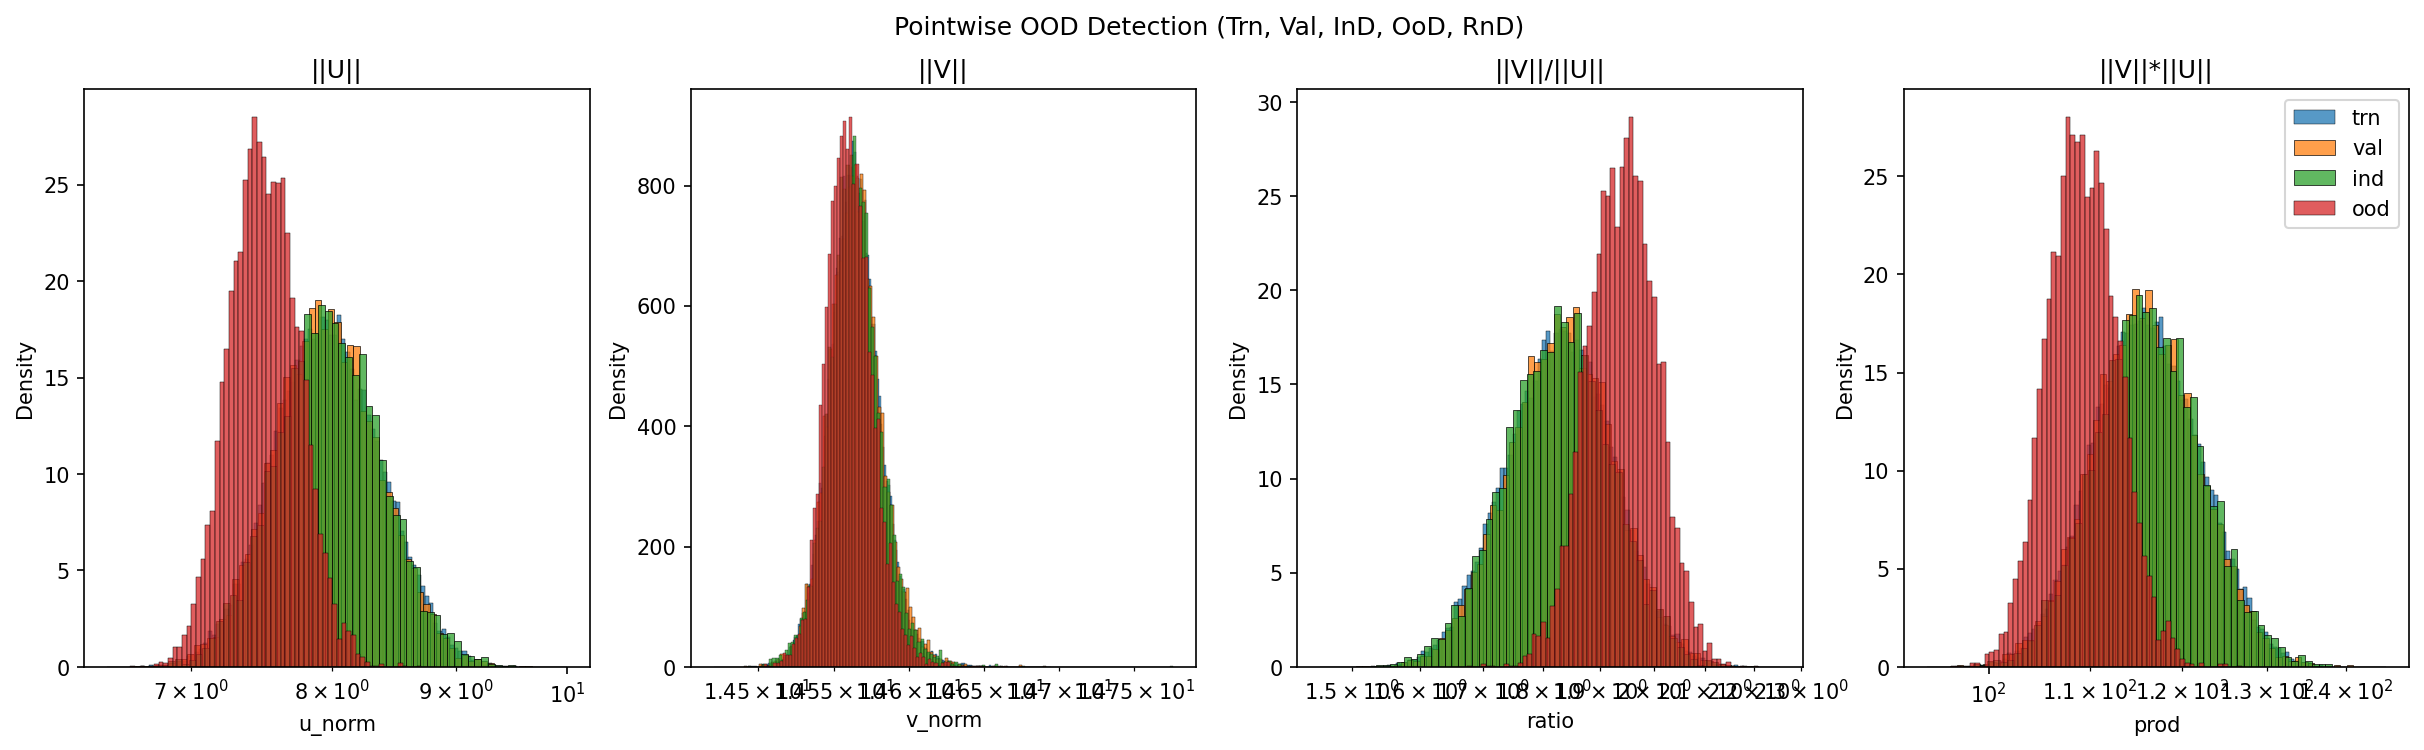

In [12]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['figure.dpi'] = 150

data_trn = pd.DataFrame(dict(u_norm=trn_u_norms, v_norm=trn_v_norms, ratio=trn_v_norms/trn_u_norms, prod=trn_v_norms*trn_u_norms, target=trn_targets))
data_val = pd.DataFrame(dict(u_norm=val_u_norms, v_norm=val_v_norms, ratio=val_v_norms/val_u_norms, prod=val_v_norms*val_u_norms, target=val_targets))
data_ind = pd.DataFrame(dict(u_norm=ind_u_norms, v_norm=ind_v_norms, ratio=ind_v_norms/ind_u_norms, prod=ind_v_norms*ind_u_norms, target=ind_targets))
if ood_str:
    data_ood = pd.DataFrame(dict(u_norm=ood_u_norms, v_norm=ood_v_norms, ratio=ood_v_norms/ood_u_norms, prod=ood_v_norms*ood_u_norms, target=ood_targets))
data_rnd = pd.DataFrame(dict(u_norm=rnd_u_norms, v_norm=rnd_v_norms, ratio=rnd_v_norms/rnd_u_norms, prod=rnd_v_norms*rnd_u_norms))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20, 5))
fig.suptitle("Pointwise OOD Detection (Trn, Val, InD, OoD, RnD)")

sns.histplot(data=data_trn, x="u_norm", log_scale=True, fill=True, label='trn', stat='density', ax=ax1)
sns.histplot(data=data_val, x="u_norm", log_scale=True, fill=True, label='val', stat='density', ax=ax1)
sns.histplot(data=data_ind, x="u_norm", log_scale=True, fill=True, label='ind', stat='density', ax=ax1)
if ood_str:
    sns.histplot(data=data_ood, x="u_norm", log_scale=True, fill=True, label='ood', stat='density', ax=ax1)
# sns.histplot(data=data_rnd, x="u_norm", log_scale=True, fill=True, label='rnd', stat='density', ax=ax1)

sns.histplot(data=data_trn, x="v_norm", log_scale=True, fill=True, label='trn', stat='density', ax=ax2)
sns.histplot(data=data_val, x="v_norm", log_scale=True, fill=True, label='val', stat='density', ax=ax2)
sns.histplot(data=data_ind, x="v_norm", log_scale=True, fill=True, label='ind', stat='density', ax=ax2)
if ood_str:
    sns.histplot(data=data_ood, x="v_norm", log_scale=True, fill=True, label='ood', stat='density', ax=ax2)
# sns.histplot(data=data_rnd, x="v_norm", log_scale=True, fill=True, label='rnd', stat='density', ax=ax2)

sns.histplot(data=data_trn, x="ratio", log_scale=True, fill=True, label='trn', stat='density', ax=ax3)
sns.histplot(data=data_val, x="ratio", log_scale=True, fill=True, label='val', stat='density', ax=ax3)
sns.histplot(data=data_ind, x="ratio", log_scale=True, fill=True, label='ind', stat='density', ax=ax3)
if ood_str:
    sns.histplot(data=data_ood, x="ratio", log_scale=True, fill=True, label='ood', stat='density', ax=ax3)
# sns.histplot(data=data_rnd, x="ratio", log_scale=True, fill=True, label='rnd', stat='density', ax=ax3)

sns.histplot(data=data_trn, x="prod", log_scale=True, fill=True, label='trn', stat='density', ax=ax4)
sns.histplot(data=data_val, x="prod", log_scale=True, fill=True, label='val', stat='density', ax=ax4)
sns.histplot(data=data_ind, x="prod", log_scale=True, fill=True, label='ind', stat='density', ax=ax4)
if ood_str:
    sns.histplot(data=data_ood, x="prod", log_scale=True, fill=True, label='ood', stat='density', ax=ax4)
# sns.histplot(data=data_rnd, x="prod", log_scale=True, fill=True, label='rnd', stat='density', ax=ax4)

ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.legend()
plt.show()

In [13]:
from scipy import stats
print("Trn", trn_v_norms.min(), trn_v_norms.max(), trn_v_norms.ptp())
print("Val", val_v_norms.min(), val_v_norms.max(), val_v_norms.ptp())
print("Ind", ind_v_norms.min(), ind_v_norms.max(), ind_v_norms.ptp())
if ood_str:
    print("Ood", ood_v_norms.min(), ood_v_norms.max(), ood_v_norms.ptp())
print("Rnd", rnd_v_norms.min(), rnd_v_norms.max(), rnd_v_norms.ptp())

if ood_str:
    ks_ind_ood = stats.kstest(ind_v_norms, ood_v_norms)
    print(ks_ind_ood)

Trn 14.471053 14.694529 0.22347546
Val 14.490764 14.691404 0.20064068
Ind 14.493365 14.776605 0.28323936
Ood 14.504288 14.665473 0.16118526
Rnd 28.252169 33.738697 5.4865284
KstestResult(statistic=0.10074060994616825, pvalue=2.7220997194168897e-37, statistic_location=14.562662, statistic_sign=-1)


[6 1 0 3 8 4 5 2 7 9]


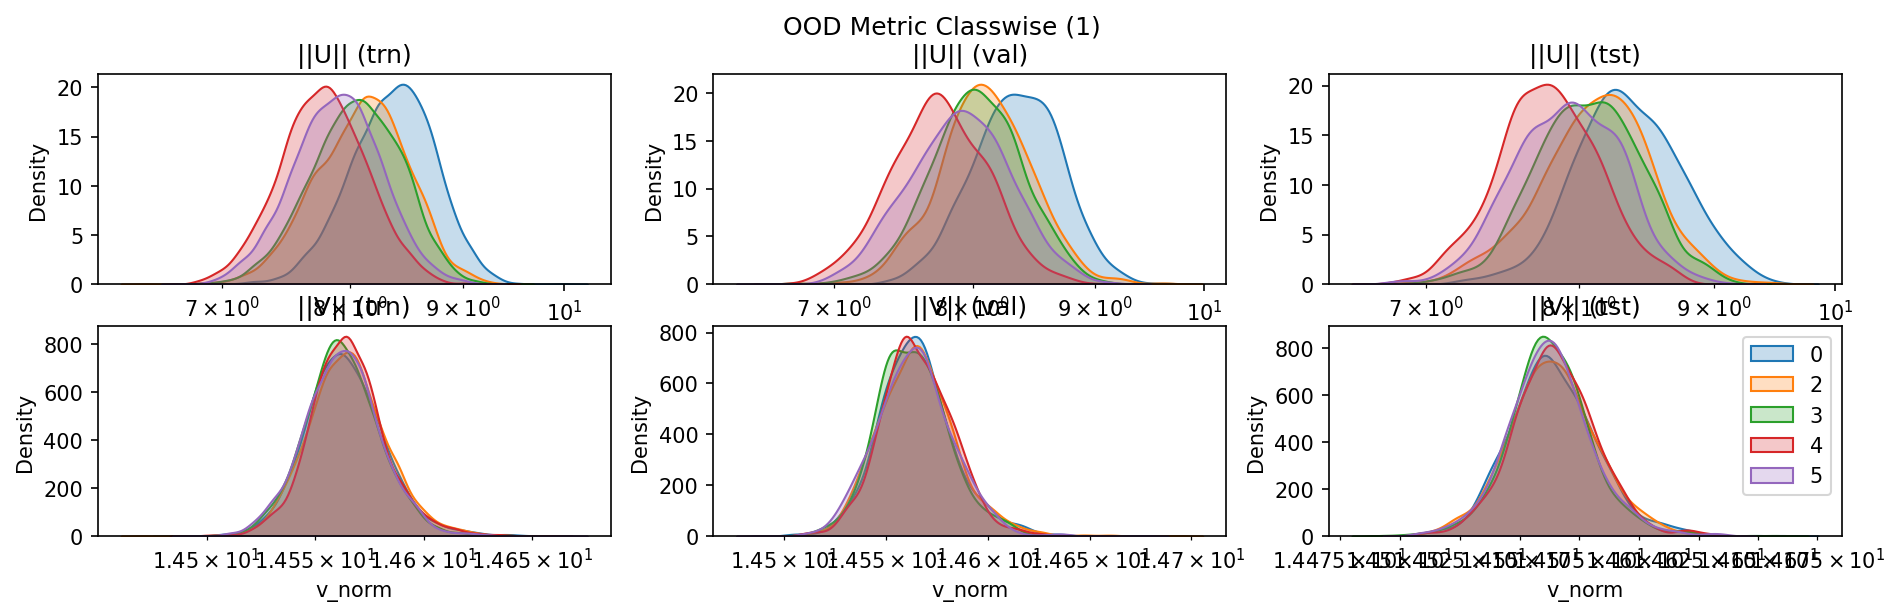

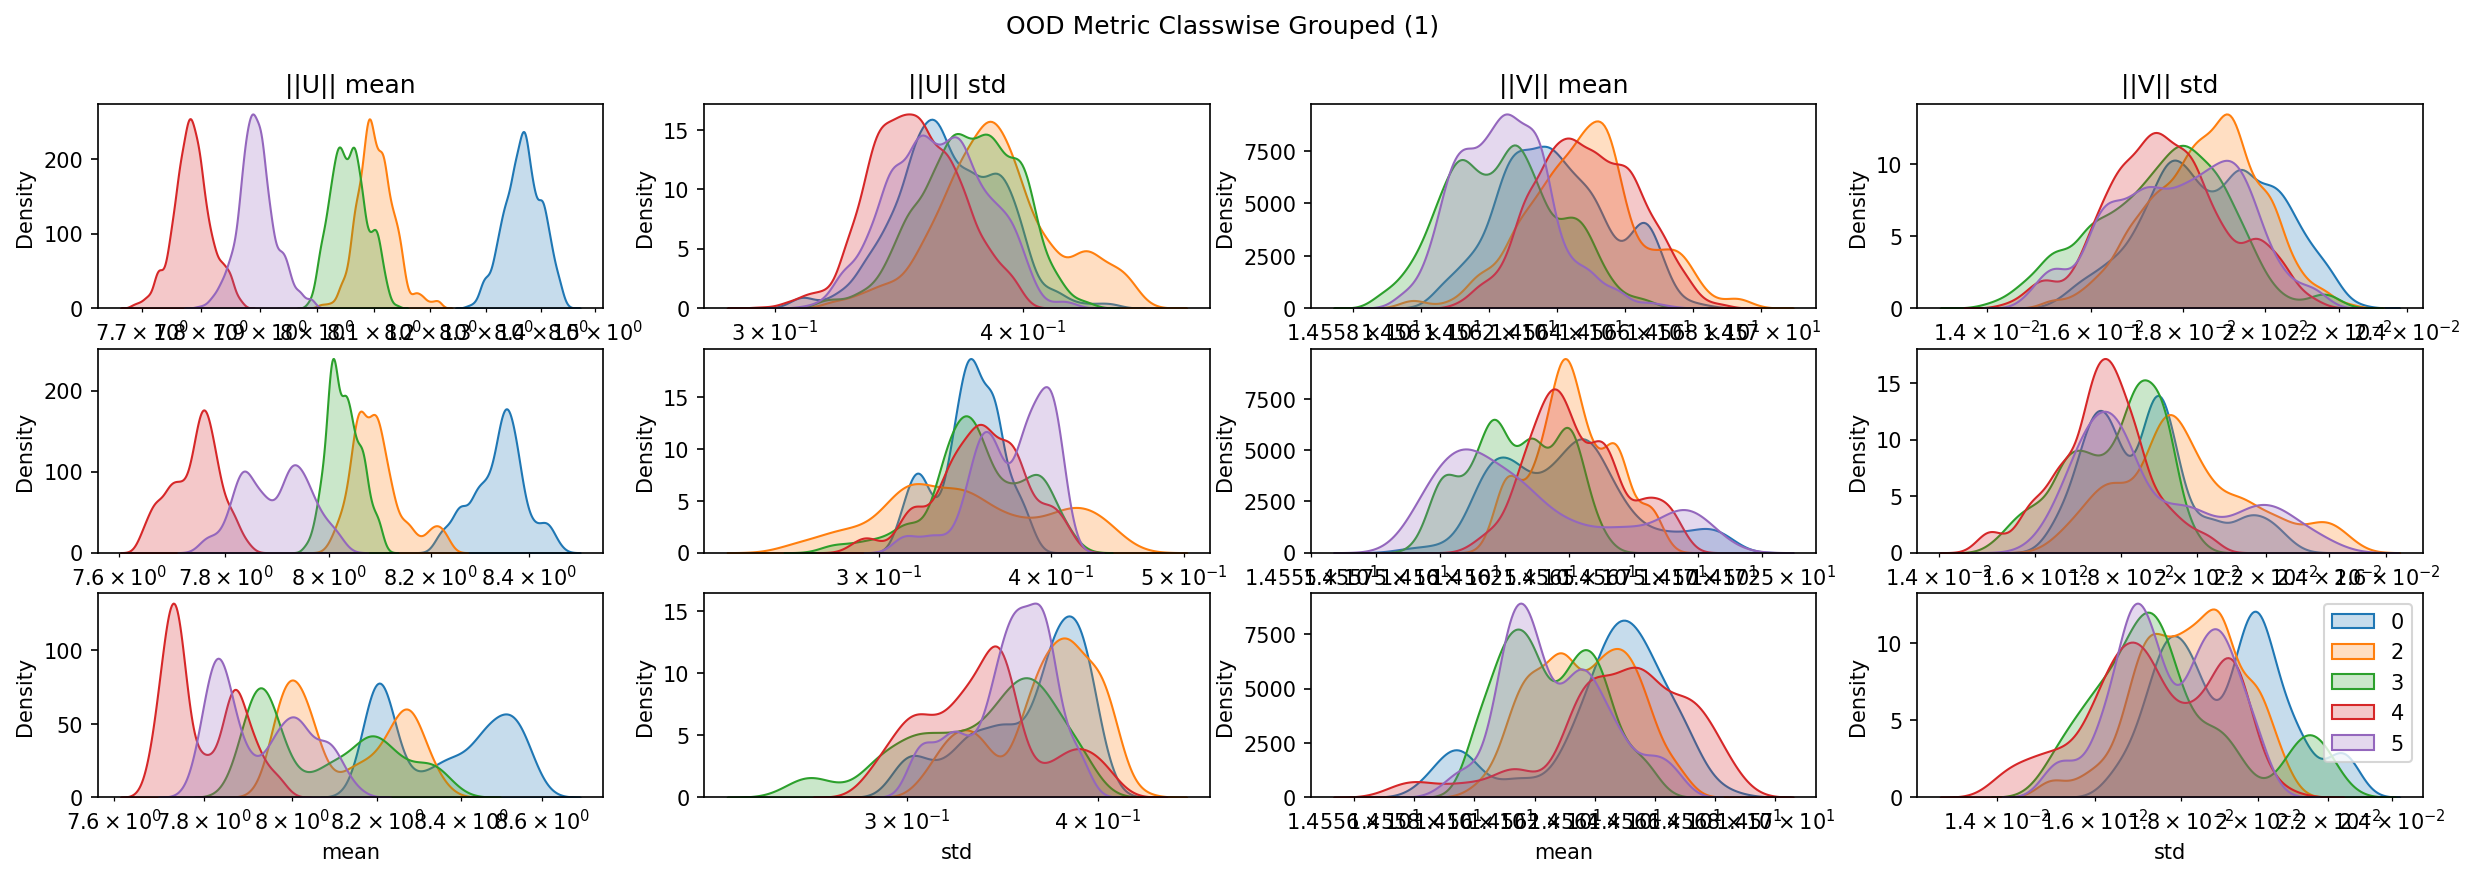

In [14]:
if ood_str:
    data_tst = pd.concat([data_ind, data_ood], axis=0)
else:
    data_tst = data_ind
print(data_tst['target'].unique())

N = 128

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(5):
    df_trn = data_trn[data_trn['target'] == i]
    df_val = data_val[data_val['target'] == i]
    df_tst = data_tst[data_tst['target'] == i]
    pointwise_trn[i] = df_trn.copy()
    pointwise_val[i] = df_val.copy()
    pointwise_tst[i] = df_tst.copy()
    groupwise_trn[i] = df_trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = df_val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = df_tst.rolling(N).agg(['mean', 'std']).dropna().copy()

# pointwise
fig, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(2, 3, figsize = (15, 4))
fig.suptitle(f"OOD Metric Classwise ({ood_str})")

for i in range(5):
    df_trn = pointwise_trn[i]
    df_val = pointwise_val[i]
    df_tst = pointwise_tst[i]
    if len(df_trn) > 0:
        sns.kdeplot(data=df_trn, x="u_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax1)
        sns.kdeplot(data=df_trn, x="v_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax4)
    if len(df_val) > 0:
        sns.kdeplot(data=df_val, x="u_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax2)
        sns.kdeplot(data=df_val, x="v_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax5)
    if len(df_tst) > 0:
        sns.kdeplot(data=df_tst, x="u_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax3)
        sns.kdeplot(data=df_tst, x="v_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax6)

ax1.title.set_text('||U|| (trn)')
ax2.title.set_text('||U|| (val)')
ax3.title.set_text('||U|| (tst)')
ax4.title.set_text('||V|| (trn)')
ax5.title.set_text('||V|| (val)')
ax6.title.set_text('||V|| (tst)')
plt.legend()
plt.show()
    
# groupwise
fig, ([ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8], [ax9, axA, axB, axC]) = plt.subplots(3, 4, figsize = (20, 6))
fig.suptitle(f"OOD Metric Classwise Grouped ({ood_str})")

for i in range(5):
    df_trn = groupwise_trn[i]
    df_val = groupwise_val[i]
    df_tst = groupwise_tst[i]
    if len(df_trn) > 0:
        sns.kdeplot(data=df_trn.u_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax1)
        sns.kdeplot(data=df_trn.u_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax2)
        sns.kdeplot(data=df_trn.v_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax3)
        sns.kdeplot(data=df_trn.v_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax4)
    if len(df_val) > 0:
        sns.kdeplot(data=df_val.u_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax5)
        sns.kdeplot(data=df_val.u_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax6)
        sns.kdeplot(data=df_val.v_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax7)
        sns.kdeplot(data=df_val.v_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax8)
    if len(df_tst) > 0:
        sns.kdeplot(data=df_tst.u_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax9)
        sns.kdeplot(data=df_tst.u_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=axA)
        sns.kdeplot(data=df_tst.v_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=axB)
        sns.kdeplot(data=df_tst.v_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=axC)

ax1.title.set_text('||U|| mean')
ax2.title.set_text('||U|| std')
ax3.title.set_text('||V|| mean')
ax4.title.set_text('||V|| std')
plt.legend()
plt.show()

In [15]:
# save vector norms for hypothesis testing

base_path = Path(f"assets/embeddings/{config.dataset_name}_{config.model_name}_M{config.emb_dims}_{ood_str}")
base_path.mkdir(exist_ok=True)

for i in range(5):
    df_trn = pointwise_trn.get(i, None)
    df_val = pointwise_val.get(i, None)
    df_tst = pointwise_tst.get(i, None)
    if df_trn is not None and len(df_trn) > 0:
        np.save(base_path / f"train_{i}.npy", df_trn.v_norm.values)
    if df_val is not None and len(df_val) > 0:
        np.save(base_path / f"val_{i}.npy", df_val.v_norm.values)
    if df_tst is not None and len(df_tst) > 0:
        np.save(base_path / f"test_{i}.npy", df_tst.v_norm.values)